This is just a test notebook

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

from consav.grids import nonlinspace # grids
from consav import linear_interp # for linear interpolation
from scipy import interpolate

# Test for discrete optimizer

In [27]:
def obj_func(x):
    y = x**2
    return y

x_range = np.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])

In [30]:
vals = obj_func(x_range)

opt_x = np.argmax(vals)
# print(obj_func(opt_x))
print(opt_x)

0


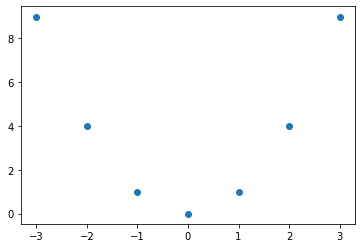

In [55]:
plt.scatter(x_range, vals)

In [68]:
temp = x_range[x_range <= 0]

temp

array([-3., -2., -1.,  0.])

# Test Consav functionality

## Interpolation

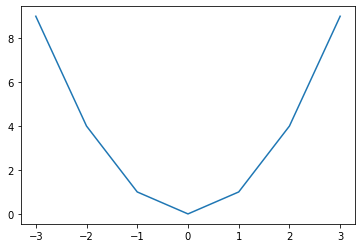

In [31]:
# Plot of the 'raw' function
plt.plot(x_range, vals)

In [38]:
# Define function to be interpolated
interp_func = interpolate.interp1d(x_range, obj_func(x_range))

# Interpolate a finer grid
interp_grid = np.linspace(-3.0,3.0,50)
interp_vals = interp_func(interp_grid)



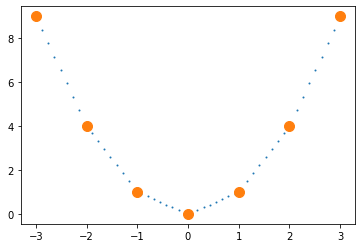

In [49]:
plt.scatter(interp_grid, interp_vals, s=1)
plt.scatter(x_range,obj_func(x_range), s = 100)

## Nonlinspace

In [24]:
Nn = 10 # number of house sizes (change later)
n_min = 0.0 # smalles house
n_max = 3.0 # largest house

n_grid = nonlinspace(n_min,n_max, Nn, 1.5)

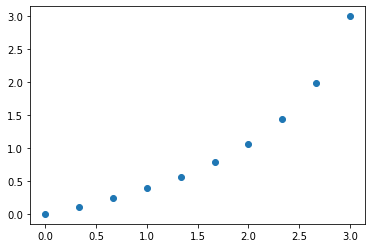

In [25]:
plt.scatter(np.linspace(n_min,n_max,Nn), n_grid)
plt.show()

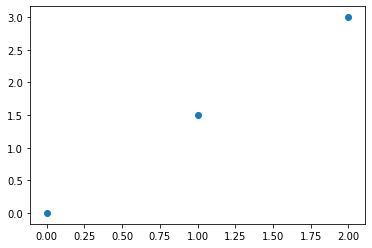

In [74]:
plt.scatter([0,1,2],n_grid)

In [3]:
min_h = 1e-2
max_h = 3.0
Nh = 5

h_grid = np.linspace(min_h, max_h, Nh)

In [4]:
print(h_grid)

[0.01   0.7575 1.505  2.2525 3.    ]


In [51]:
m = 10 - h_grid
m

array([9.99  , 9.2425, 8.495 , 7.7475, 7.    ])

Check interpolation here

In [85]:
x = np.linspace(0,1,10)
y = np.where(x <= 0.5)
# y = x[x<=0.5]
print(y)
# y[1] = 4

(array([0, 1, 2, 3, 4], dtype=int64),)


In [27]:
# Generate transition matrix
p_12 = 1/3
p_21 = 1/3
P = np.array([[1-p_12,p_12],[p_21,1-p_21]])

print(P)
P[0] # First index is the row

[[0.66666667 0.33333333]
 [0.33333333 0.66666667]]


array([0.66666667, 0.33333333])

In [40]:
p_12 = 0.33 # Transition probability
p_21 = 0.33
p_mat = np.array([  # Stochastic matrix for income
    [1-p_12, p_12], 
    [p_21, 1-p_21]])
print(p_mat)

p_mat[0][0]


[[0.67 0.33]
 [0.33 0.67]]


0.6699999999999999